In [14]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [15]:
#Se leen los datos y se seleccionan las variables que presentan una diferencia
# entre los individuos que presentan estres y los que no
data_path = Path(os.getcwd()).parent / "data"
silver_path = data_path / "silver" / "dreaddit_clean.csv"
df = pd.read_csv(silver_path, usecols= ["text","clean_text","clean_text_sentence_sep",
                                        "singular_pronouns", "avg_word_len",'lex_diversity',"label"])

In [16]:
#Configuracion de visualizaciones 

# Configurar el estilo de fondo con una cuadrícula
sns.set_style("whitegrid")

# Establecer una paleta de colores profesional
sns.set_palette("pastel")

# Configurar la tipografía y el tamaño de la fuente
sns.set_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", "font.sans-serif": ["Helvetica", "Arial"]})

# Desactivar spines innecesarios
sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'Registros')

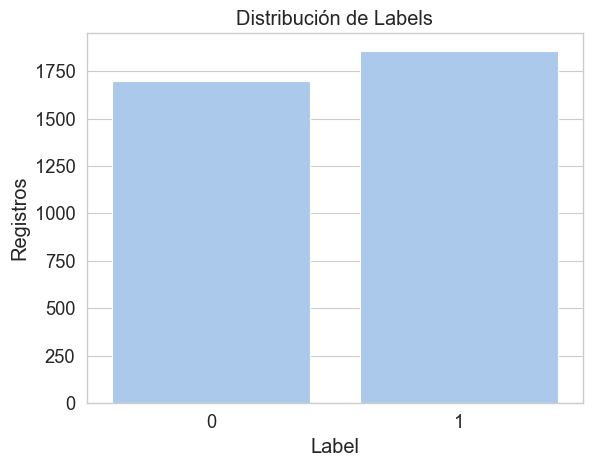

In [17]:
#distribucion de categorias en el label
label_dis = df.label.value_counts().reset_index()

g = sns.barplot(x="label", y="count", data=label_dis)
g.set_title("Distribución de Labels")
g.set_xlabel("Label")
g.set_ylabel("Registros")


In [18]:
features =['singular_pronouns', 'avg_word_len', 'lex_diversity']
X = df.loc[:,features]
y = df.label
feature_corr = X.corr()

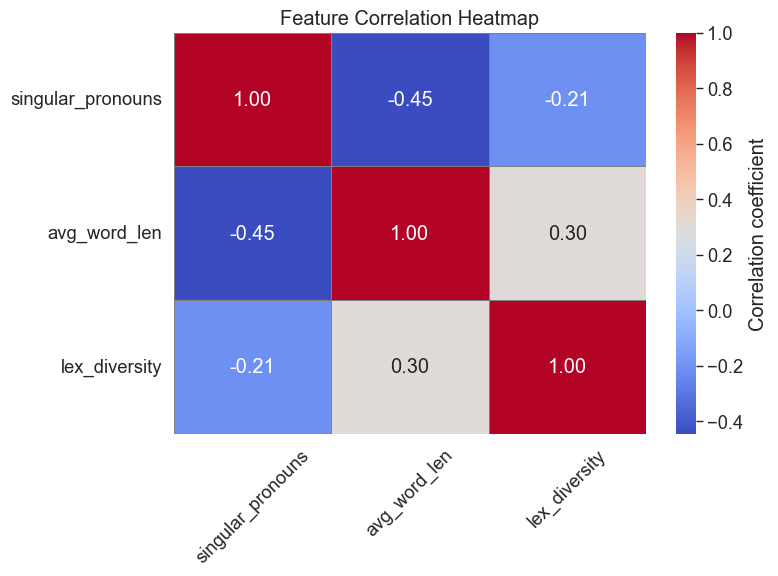

In [19]:
# Create the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='gray')

plt.title('Feature Correlation Heatmap')  # Add a title to the heatmap
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

#### **Entrenamiento y evaluacion de modelos**

In [20]:
def get_models():
    """
    Initializes a dictionary of machine learning models with some predefined parameters.
    
    Returns:
        dict: A dictionary containing initialized models with their respective names.
    """
    models = {
        'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(solver='saga', C=70.0)),
        'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier()),
        'Decision Tree': DecisionTreeClassifier(max_depth=1),
        'SVM': make_pipeline(StandardScaler(), SVC()),
        'Naive Bayes': make_pipeline(StandardScaler(), GaussianNB()),
        'XGBoost': XGBClassifier(n_estimators=11, max_depth=1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=10),
        'Random Forest': RandomForestClassifier(n_estimators=10),
        'AdaBoost': AdaBoostClassifier(n_estimators=12)
    }
    return models

def evaluate_model(model, X, y):
    """
    Evaluates a given model using cross-validation.
    
    Args:
        model: The machine learning model to evaluate.
        X: Feature dataset.
        y: Target variable.
    
    Returns:
        np.array: F1 scores from the cross-validation.
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return scores



In [21]:
# Get and evaluate models
models = get_models()
results, names = [], []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(f'>{name}: Mean F1 score = {scores.mean():.2f} with Std = {scores.std():.2f}')

>Logistic Regression: Mean F1 score = 0.69 with Std = 0.01
>K-Nearest Neighbors: Mean F1 score = 0.64 with Std = 0.01
>Decision Tree: Mean F1 score = 0.72 with Std = 0.01
>SVM: Mean F1 score = 0.71 with Std = 0.01
>Naive Bayes: Mean F1 score = 0.70 with Std = 0.01
>XGBoost: Mean F1 score = 0.71 with Std = 0.02
>Gradient Boosting: Mean F1 score = 0.71 with Std = 0.02
>Random Forest: Mean F1 score = 0.61 with Std = 0.02
>AdaBoost: Mean F1 score = 0.71 with Std = 0.01


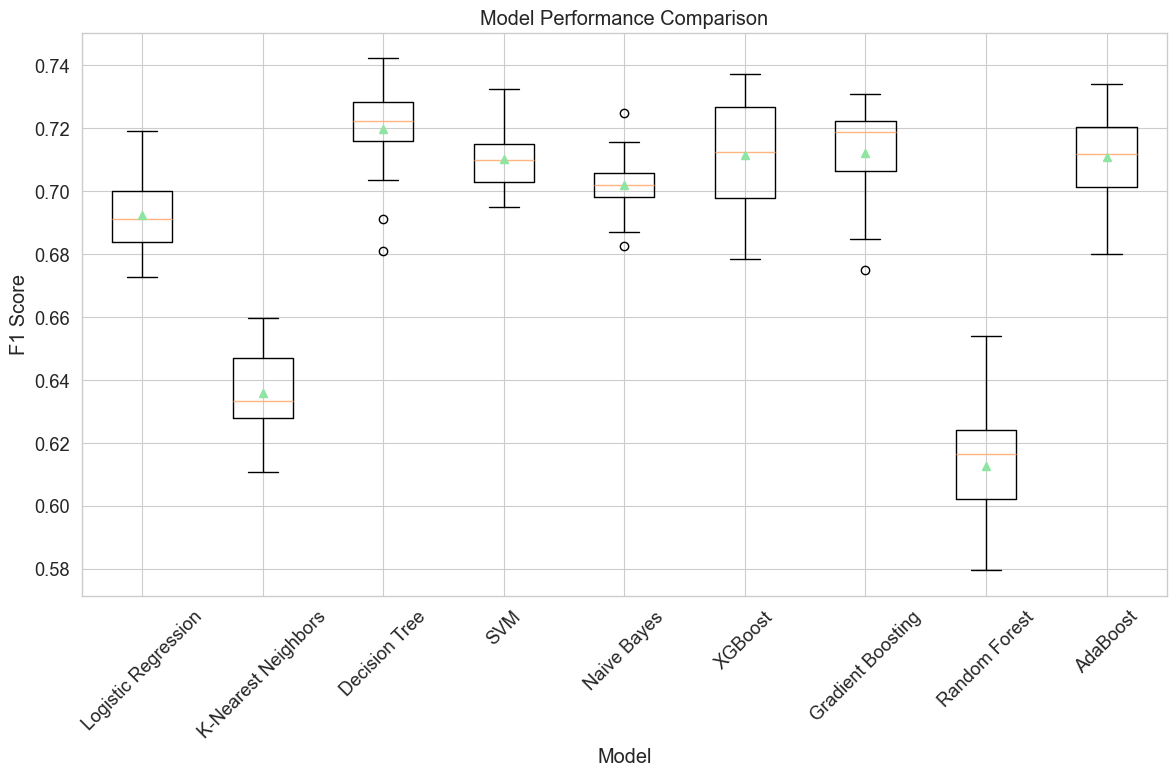

In [22]:
# Plotting model performance for comparison using boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


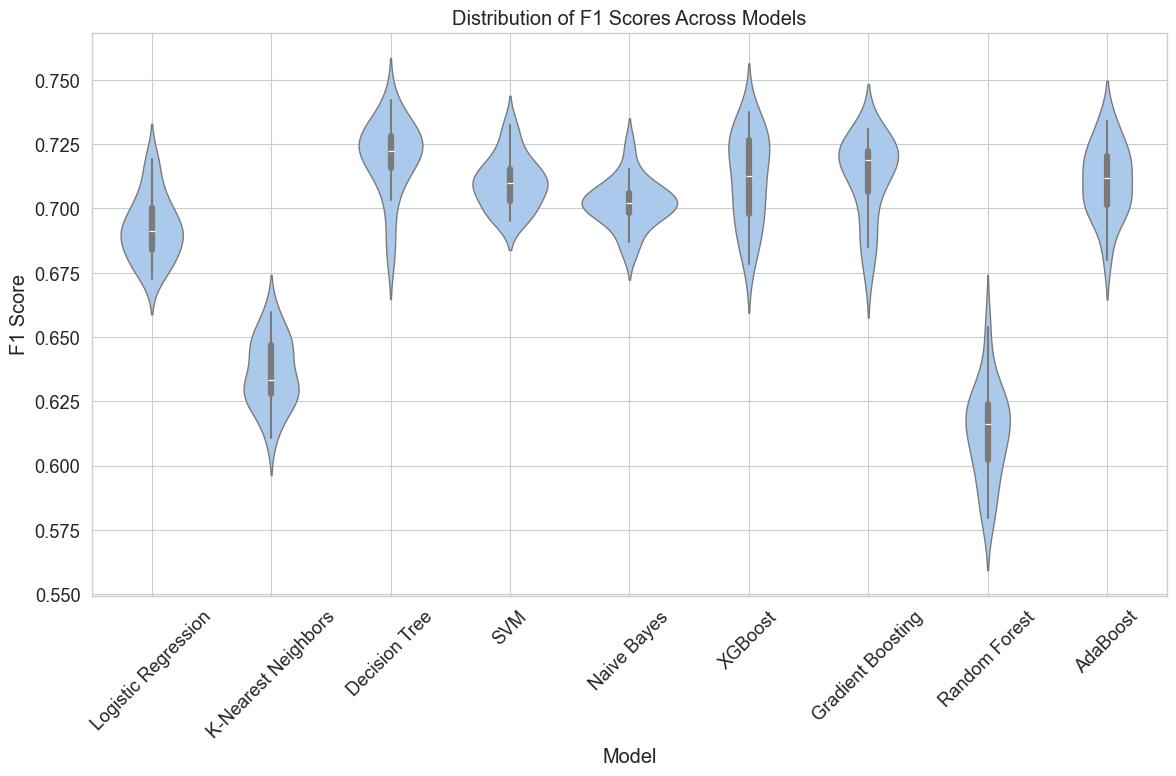

In [23]:
# Create a DataFrame for plotting
data = pd.DataFrame(data={name: scores for name, scores in zip(names, results)})
# Melt the DataFrame for easier plotting with seaborn
data_melted = data.melt(var_name='Model', value_name='F1 Score')

# Create the violin plot
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size as needed
sns.violinplot(x='Model', y='F1 Score', data=data_melted)
plt.title('Distribution of F1 Scores Across Models')  # Add a title to the plot
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.xlabel('Model')  # Label for the x-axis
plt.ylabel('F1 Score')  # Label for the y-axis
plt.grid(True)  # Optional: Add a grid for better readability
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

#### **Importancia de features**

In [7]:
#Se separan los datos y se entrena un modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier().fit(X_train, y_train)

In [8]:
# Crear el objeto Explainer
explainer = shap.Explainer(model, X_train)
# Calcular SHAP values
shap_values = explainer(X_test)

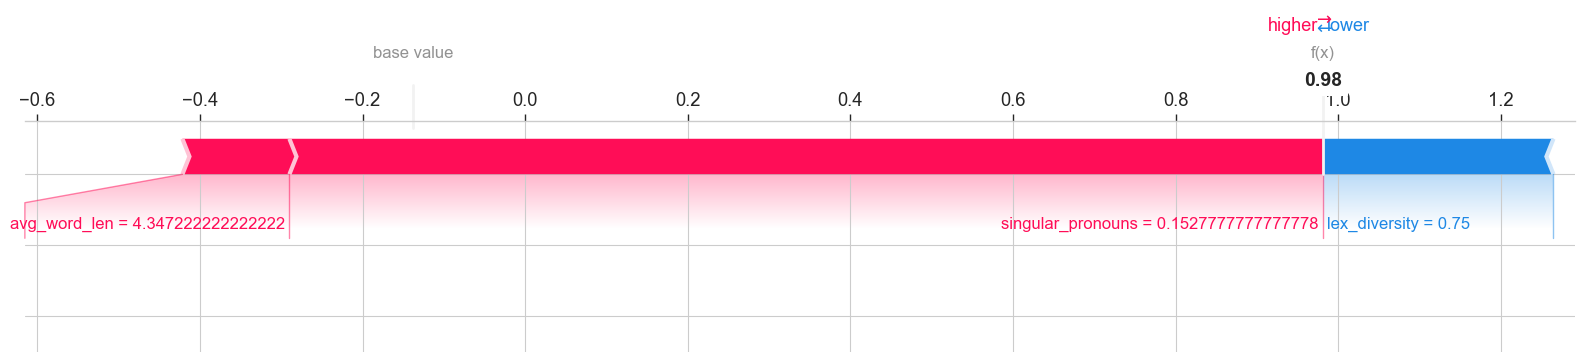

In [9]:
# Visualizar el primer prediccion
shap.plots.force(shap_values[10], matplotlib=True)

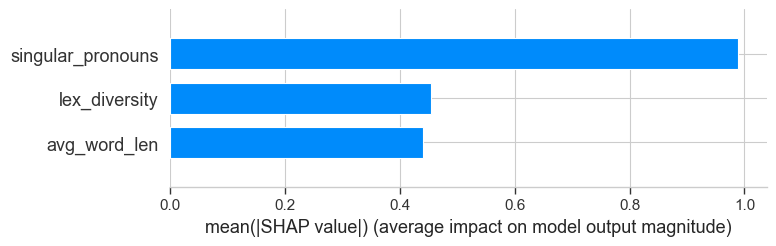

In [10]:
shap.summary_plot(shap_values, X, plot_type="bar")


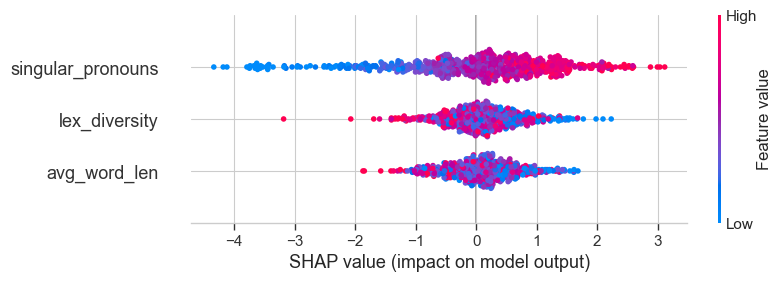

In [11]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [12]:
#shap.initjs()
#shap.force_plot(shap_values[:1000])